# Using neural network model to predict stroke
Thesis<br>
Jori Nordlund<br>
Helsinki Metropolia University of Applied Sciences<br>
04.03.2021

## Background

The purpose of this document is to find out whether neural network model can be used for predicting if a person has had a stroke or not based on the given data. If the model works with reasonable accuracy it could be for example used in trying to recognize people with high risk of having stroke. Data used in this document was originally aquired from [Kaggle](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset).

## Imports

In [1]:
%pylab inline
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


## Data

In [2]:
# Original data can be found from https://www.kaggle.com/fedesoriano/stroke-prediction-dataset

df = pd.read_csv('./healthcare-dataset-stroke-data.csv',index_col = None, header = None)

print("Dataset has: " + str(df.shape[0]) + " samples.")

Dataset has: 5109 samples.


In [3]:
df.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11
0,9046,0,67.0,0,1,1,0,0,228.69,36.6,2,1
1,51676,1,61.0,0,0,1,3,1,202.21,NaN,1,1
2,31112,0,80.0,0,1,1,0,1,105.92,32.5,1,1
3,60182,1,49.0,0,0,1,0,0,171.23,34.4,3,1
4,1665,1,79.0,1,0,1,3,1,174.12,24.0,1,1
5,56669,0,81.0,0,0,1,0,0,186.21,29.0,2,1
6,53882,0,74.0,1,1,1,0,1,70.09,27.4,1,1
7,10434,1,69.0,0,0,0,0,0,94.39,22.8,1,1
8,27419,1,59.0,0,0,1,0,1,76.15,NaN,0,1
9,60491,1,78.0,0,0,1,0,0,58.57,24.2,0,1


In [3]:
stroke = (df[11].values == 1).sum()
print("Amount of people who has had a stroke: " + str(stroke))
print("Amount of people who has not had a stroke: " + str(df.shape[0] - stroke))

Amount of people who has had a stroke: 249
Amount of people who has not had a stroke: 4860


In [4]:
# A way to find the missing values from the dataset
# https://stackoverflow.com/questions/30447083/python-pandas-return-only-those-rows-which-have-missing-values
missing_values = df[df.isnull().any(axis=1)]

In [5]:
missing_positive = (missing_values[11].values == 1).sum()
print("Amount of positive samples that would be missed by dropping rows with missing values: " + str(missing_positive))

Amount of positive samples that would be missed by dropping rows with missing values: 40


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5109 entries, 0 to 5108
Data columns (total 12 columns):
0     5109 non-null int64
1     5109 non-null int64
2     5109 non-null float64
3     5109 non-null int64
4     5109 non-null int64
5     5109 non-null int64
6     5109 non-null int64
7     5109 non-null int64
8     5109 non-null float64
9     4908 non-null float64
10    5109 non-null int64
11    5109 non-null int64
dtypes: float64(3), int64(9)
memory usage: 479.1 KB


In [7]:
# Dropping the 'id' column from the data since it is not relevant to the process of training the model
df = df.drop([0], axis=1)

# Dropping samples with missing values
#df = df.dropna()

# Another way to approach missing values is to fill with value of '0'
df = df.fillna(0)


#Shuffling the dataset
# Originally the data had almost all the positive outcomes at the beginning and that was problematic 
# when it came to splitting the data.
# https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows

df = df.sample(frac=1, random_state=40) # Using 'random_state' to make sure data is always suffled the same way.

#Resetting the indices of the dataset
df = df.reset_index(drop=True)

In [8]:
stroke = (df[11].values == 1).sum()
print("Amount of people who has had a stroke: " + str(stroke))
print("Amount of people who has not had a stroke: " + str(df.shape[0] - stroke))

Amount of people who has had a stroke: 249
Amount of people who has not had a stroke: 4860


In [9]:
# Original dataset has 5109 samples so approximately 20% of the samples would be lost if all the samples with missing values
# were dropped.

print("Samples in total: " +  str(df.shape[0]))

Samples in total: 5109


In [10]:
(df[10].values  == 0).sum()

1544

In [11]:
df.describe()

,1,2,3,4,5,6,7,8,9,10,11
count,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000
mean,0.586025,43.229986,0.097475,0.054022,0.656293,1.268546,0.491877,106.140399,27.757780,1.179683,0.048738
std,0.492592,22.613575,0.296633,0.226084,0.474991,1.560046,0.499983,45.285004,9.530135,1.029998,0.215340
min,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,55.120000,0.000000,0.000000,0.000000
25%,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,77.240000,22.900000,0.000000,0.000000
50%,1.000000,45.000000,0.000000,0.000000,1.000000,0.000000,0.000000,91.880000,27.700000,1.000000,0.000000
75%,1.000000,61.000000,0.000000,0.000000,1.000000,3.000000,1.000000,114.090000,32.800000,2.000000,0.000000
max,1.000000,82.000000,1.000000,1.000000,1.000000,4.000000,1.000000,271.740000,97.600000,3.000000,1.000000


### Attributes
In the original dataset some of the attributes are represented with using words instead of numbers. These attribute values are replaced with numbers that correspond to the previous value. For example in the original dataset attribute "work_type" has five unique values that are as follows: "Private", "Never_worked", "children", "Self-employed" and "Govt_job". These values are replaced with numbers from 0-4 to make it possible to use this attribute in the process of training the neural network.
       

1. Gender (gender)
- '0' = Male
- '1' = Female
- binary


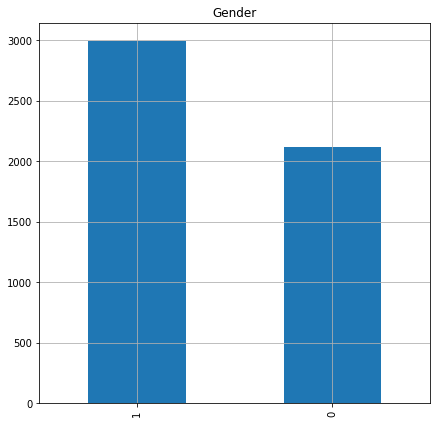

2. Age (age)
- age in years
- Minimum = 0.08 (about one month)
- Maximum = 82
- Mean = 43
- numeric


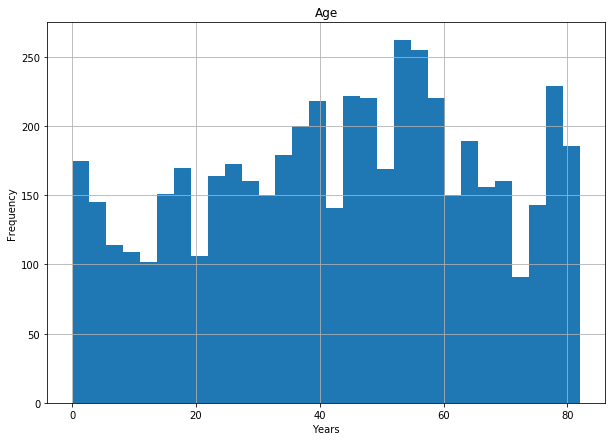

3. Hypertension (hypertension)
- '0' = Patient doesn't have hypertension
- '1' = Patient has hypertension
- binary


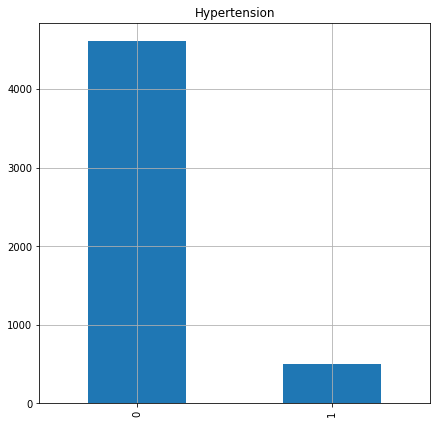

4. Heart disease (heart_disease)
- '0' = Patient doesn't have heart diseases
- '1' = Patient has heart disease
- binary


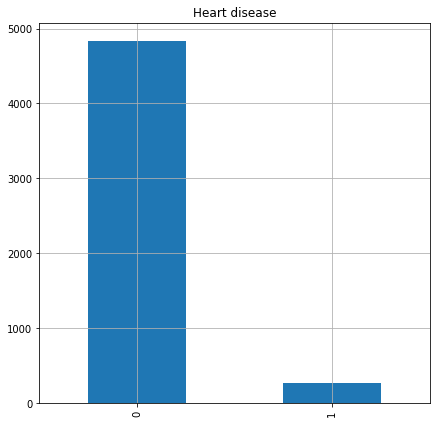

5. Marriage (ever_married)
- '0' = The patient has not been married (No)
- '1' = The patient is married or has been married (Yes)
- binary


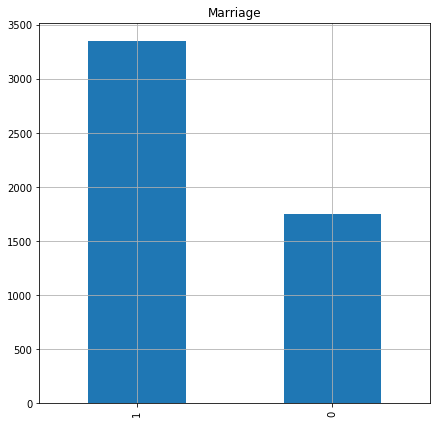

6. Type of work (work_type)
- '0' = Private
- '1' = Never worked
- '2' = Taking care of children
- '3' = Self-employed
- '4' = Government job
- categorical


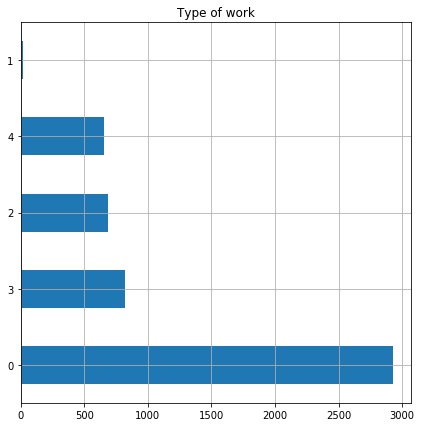

7. Type of residence (Residence_type)
- '0' = Urban
- '1' = Rural
- binary


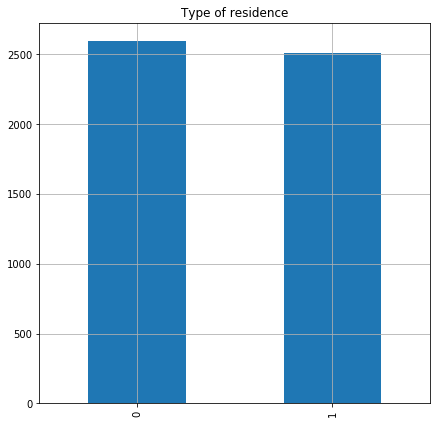

8. Average blood sugar level (avg_glucose_level)
- Patients average blood sugar level (mg/dL)
- Minimum value = 55.12
- Maximum value = 271.74
- Mean = 105
- numeric


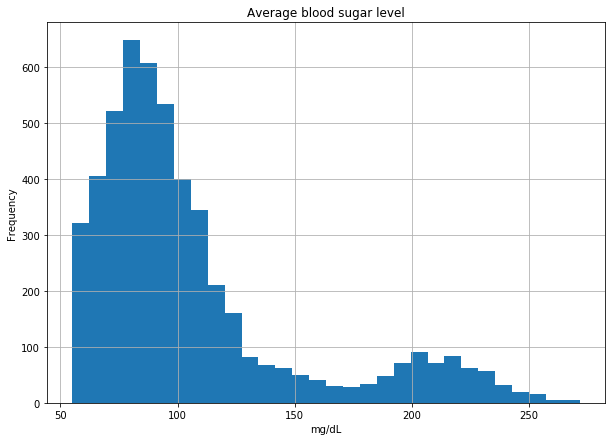

9. Body mass index (bmi)
- Patients body mass index (kg/m^2)
- Minimum value = 10.3
- Maximum value = 97.6
- Mean = 27.76
- numeric


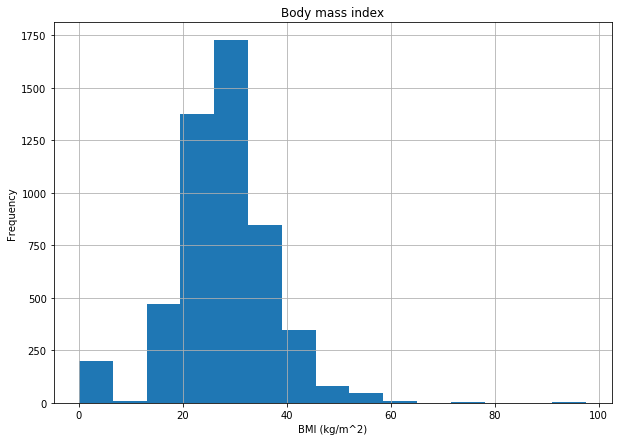

10. Smoking status (smoking_status)
- '0' = Unknown
- '1' = Never smoked
- '2' = Formerly smoked
- '3' = Smokes
- categorical


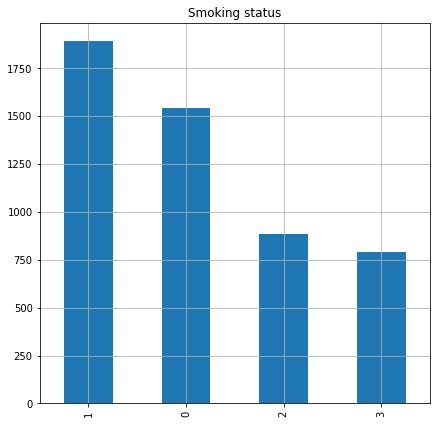

11. Stroke (stroke)
- '0' = Patient hasn't had a stroke
- '1' = Patient has had a stroke
- binary


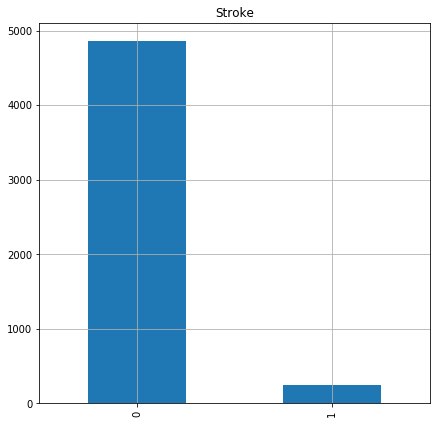

In [12]:
print("1. Gender (gender)\n- '0' = Male\n- '1' = Female\n- binary")
df[1].value_counts().plot(kind='bar', figsize=(7,7))
plt.title('Gender')
plt.grid()
plt.show()

print("2. Age (age)\n- age in years\n- Minimum = 0.08 (about one month)\n- Maximum = 82\n- Mean = 43\n- numeric")
df[2].plot(kind='hist',bins=30, figsize=(10,7))
plt.title('Age')
plt.grid()
plt.xlabel('Years')
plt.show()

print("3. Hypertension (hypertension)\n- '0' = Patient doesn't have hypertension\n- '1' = Patient has hypertension\n- binary")
df[3].value_counts().plot(kind='bar', figsize=(7,7))
plt.title('Hypertension')
plt.grid()
plt.show()

print("4. Heart disease (heart_disease)\n- '0' = Patient doesn't have heart diseases\n- '1' = Patient has heart disease\n- binary")
df[4].value_counts().plot(kind='bar', figsize=(7,7))
plt.title('Heart disease')
plt.grid()
plt.show()

print("5. Marriage (ever_married)\n- '0' = The patient has not been married (No)\n- '1' = The patient is married or has been married (Yes)\n- binary")
df[5].value_counts().plot(kind='bar', figsize=(7,7))
plt.title('Marriage')
plt.grid()
plt.show()

print("6. Type of work (work_type)\n- '0' = Private\n- '1' = Never worked\n- '2' = Taking care of children\n- '3' = Self-employed\n- '4' = Government job\n- categorical")
df[6].value_counts().plot(kind='barh', figsize=(7,7))
plt.title('Type of work')
plt.grid()
plt.show()

print("7. Type of residence (Residence_type)\n- '0' = Urban\n- '1' = Rural\n- binary")
df[7].value_counts().plot(kind='bar', figsize=(7,7) )
plt.title('Type of residence')
plt.grid()
plt.show()

print("8. Average blood sugar level (avg_glucose_level)\n- Patients average blood sugar level (mg/dL)\n- Minimum value = 55.12\n- Maximum value = 271.74\n- Mean = 105\n- numeric")
df[8].plot(kind='hist', bins=30, figsize=(10,7))
plt.title('Average blood sugar level')
plt.grid()
plt.xlabel('mg/dL')
plt.show()

print("9. Body mass index (bmi)\n- Patients body mass index (kg/m^2)\n- Minimum value = 10.3\n- Maximum value = 97.6\n- Mean = 27.76\n- numeric")
df[9].plot(kind='hist', bins=15, figsize=(10,7))
plt.title('Body mass index')
plt.grid()
plt.xlabel('BMI (kg/m^2)')
plt.show()

print("10. Smoking status (smoking_status)\n- '0' = Unknown\n- '1' = Never smoked\n- '2' = Formerly smoked\n- '3' = Smokes\n- categorical")
df[10].value_counts().plot(kind='bar', figsize=(7,7))
plt.title('Smoking status')
plt.grid()
plt.show()

print("11. Stroke (stroke)\n- '0' = Patient hasn't had a stroke\n- '1' = Patient has had a stroke\n- binary")
df[11].value_counts().plot(kind='bar', figsize=(7,7))
plt.title('Stroke')
plt.grid()
plt.show()

In [13]:
# Separating the data values and labels
data = df.loc[:, 1:10]
labels = df.loc[:,11]

# Splitting the data for training and validation
# 'test_size' defines the percentage of data used for validation
data_train, data_val, labels_train, labels_val = train_test_split(data,labels,test_size=0.3, random_state=40)

# Scaling the data
data_train = preprocessing.scale(data_train)
data_val = preprocessing.scale(data_val)

In [14]:
# Amount of samples used for validation
val_samples = len(labels_val.values)

#Amount of positive samples in validation
val_stroke = 0

for i in range(len(labels_val.values)):
    if labels_val.values[i] == 1:
        val_stroke = val_stroke + 1
        
print("Amount of samples used for validation: " + str(val_samples))
print("Amount of samples that had a stroke used for validation: " + str(val_stroke))

Amount of samples used for validation: 1533
Amount of samples that had a stroke used for validation: 67


In [15]:
# Calculating the percentage of positive samples in validation
percentage = val_stroke / val_samples * 100

print("\nPercentage of samples that had a stroke in validation data: %.2f" % percentage + "%")


Percentage of samples that had a stroke in validation data: 4.37%


## Creating and training the models

In [16]:
# Creating the model
model_first = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation='relu', input_shape = (10,)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compiling the model
model_first.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
model_first.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                110       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                704       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 879
Trainable params: 879
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Creating another much more complicated model for comparison
model_second = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation='relu', input_shape = (10,)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compiling the model
model_second.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [19]:
model_second.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2816      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 44,143
Trainable params: 44,143
Non-trainable params: 0
__________________________________________________

## Training and evaluation of the first model

In [20]:
# Best results
# batch_size = 30
# epochs = 50

batch = 20
epochs = 50

history_first = model_first.fit(data_train, labels_train, batch_size=batch, epochs=epochs, validation_data=(data_val, labels_val))

# Saving the model for possible comparison later with different models
#model.save('Stroke_prediction_model.h10')

Train on 3576 samples, validate on 1533 samples
Epoch 1/50
3576/3576 [==============================] - 1s 301us/sample - loss: 0.2956 - accuracy: 0.9279 - val_loss: 0.1723 - val_accuracy: 0.9563
Epoch 2/50
3576/3576 [==============================] - 0s 82us/sample - loss: 0.1888 - accuracy: 0.9491 - val_loss: 0.1583 - val_accuracy: 0.9563
Epoch 3/50
3576/3576 [==============================] - 0s 83us/sample - loss: 0.1805 - accuracy: 0.9491 - val_loss: 0.1562 - val_accuracy: 0.9543
Epoch 4/50
3576/3576 [==============================] - 0s 80us/sample - loss: 0.1759 - accuracy: 0.9491 - val_loss: 0.1527 - val_accuracy: 0.9543
Epoch 5/50
3576/3576 [==============================] - 0s 83us/sample - loss: 0.1718 - accuracy: 0.9485 - val_loss: 0.1519 - val_accuracy: 0.9550
Epoch 6/50
3576/3576 [==============================] - 0s 82us/sample - loss: 0.1692 - accuracy: 0.9488 - val_loss: 0.1507 - val_accuracy: 0.9556
Epoch 7/50
3576/3576 [==============================] - 0s 82us/sampl

### Training and validation loss

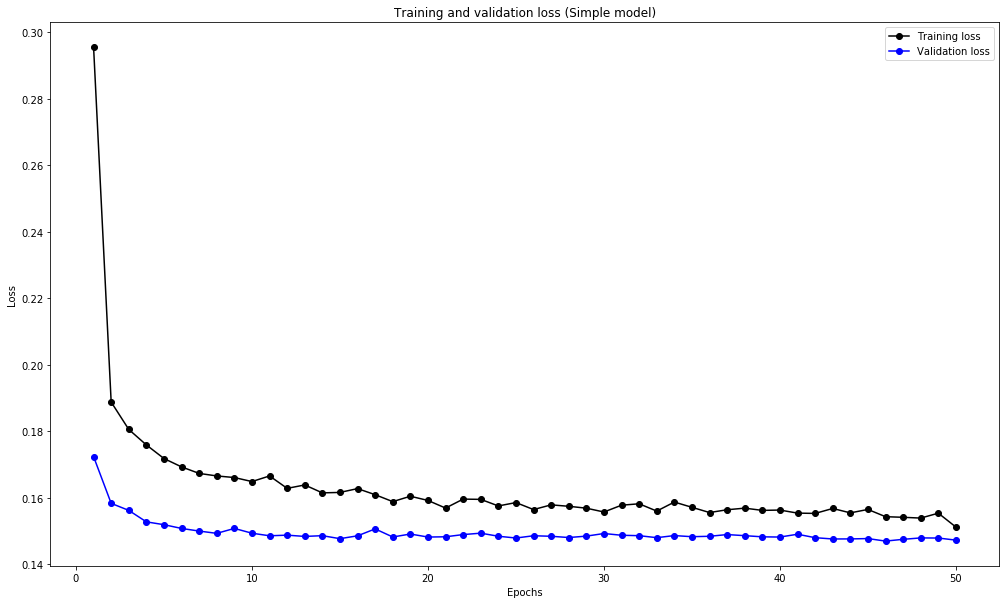

In [26]:
loss = history_first.history['loss']
val_loss = history_first.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(17,10))
plt.plot(epochs, loss, '-ok', label='Training loss')
plt.plot(epochs, val_loss, '-ob', label='Validation loss')
plt.title('Training and validation loss (Simple model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Training and validation accuracy

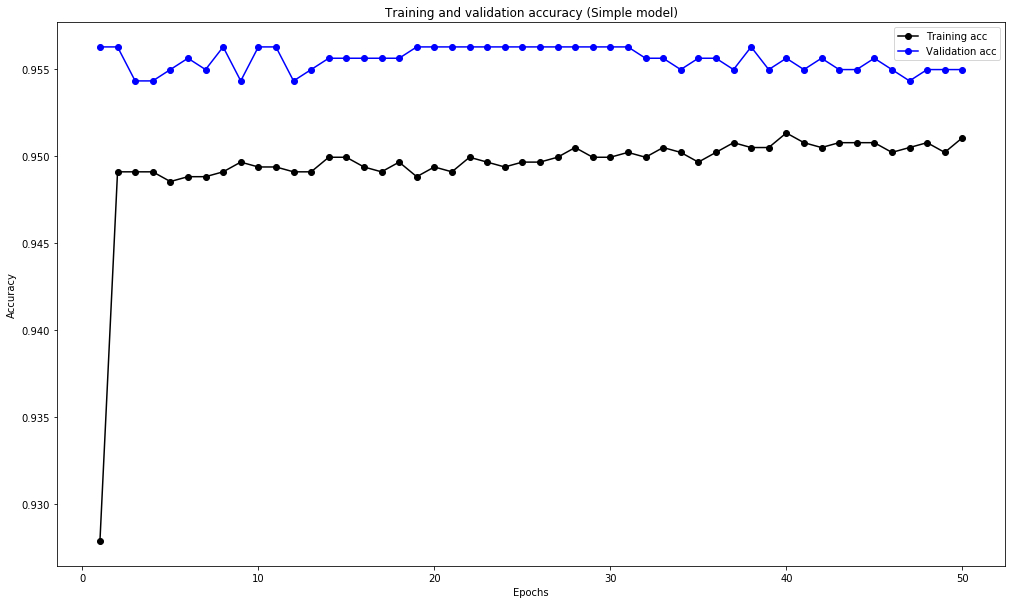

In [28]:
acc = history_first.history['accuracy']
val_acc = history_first.history['val_accuracy']
plt.figure(figsize=(17,10))
plt.plot(epochs, acc, '-ok', label='Training acc')
plt.plot(epochs, val_acc, '-ob', label='Validation acc')
plt.title('Training and validation accuracy (Simple model)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Training and evaluation of the second model

In [23]:
batch = 30
epochs = 50
history_second = model_second.fit(data_train, labels_train, batch_size=batch, epochs=epochs, validation_data=(data_val, labels_val))

Train on 3576 samples, validate on 1533 samples
Epoch 1/50
3576/3576 [==============================] - 1s 345us/sample - loss: 0.2191 - accuracy: 0.9441 - val_loss: 0.1636 - val_accuracy: 0.9563
Epoch 2/50
3576/3576 [==============================] - 0s 92us/sample - loss: 0.1800 - accuracy: 0.9491 - val_loss: 0.1534 - val_accuracy: 0.9563
Epoch 3/50
3576/3576 [==============================] - 0s 90us/sample - loss: 0.1748 - accuracy: 0.9491 - val_loss: 0.1562 - val_accuracy: 0.9563
Epoch 4/50
3576/3576 [==============================] - 0s 85us/sample - loss: 0.1737 - accuracy: 0.9491 - val_loss: 0.1662 - val_accuracy: 0.9563
Epoch 5/50
3576/3576 [==============================] - 0s 89us/sample - loss: 0.1695 - accuracy: 0.9491 - val_loss: 0.1515 - val_accuracy: 0.9563
Epoch 6/50
3576/3576 [==============================] - 0s 88us/sample - loss: 0.1658 - accuracy: 0.9491 - val_loss: 0.1492 - val_accuracy: 0.9563
Epoch 7/50
3576/3576 [==============================] - 0s 90us/sampl

### Training and validation loss

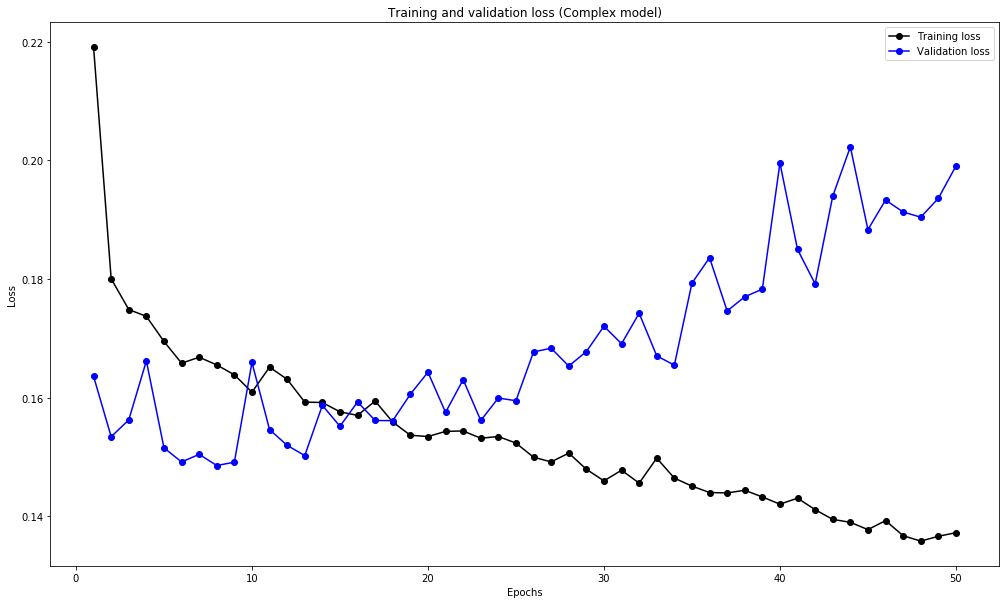

In [29]:
loss = history_second.history['loss']
val_loss = history_second.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(17,10))
plt.plot(epochs, loss, '-ok', label='Training loss')
plt.plot(epochs, val_loss, '-ob', label='Validation loss')
plt.title('Training and validation loss (Complex model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Training and validation accuracy

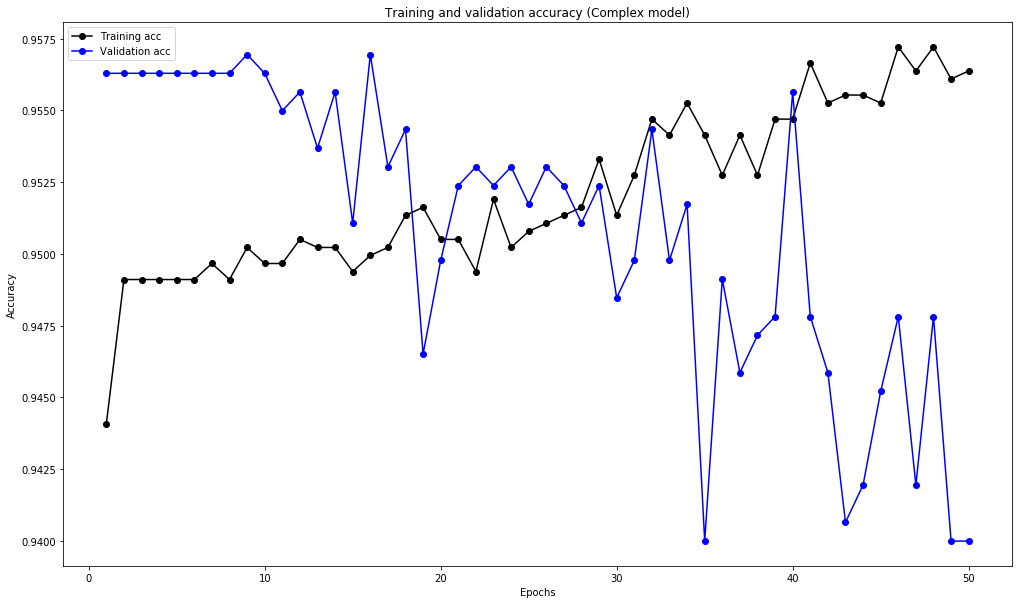

In [30]:
acc = history_second.history['accuracy']
val_acc = history_second.history['val_accuracy']
plt.figure(figsize=(17,10))
plt.plot(epochs, acc, '-ok', label='Training acc')
plt.plot(epochs, val_acc, '-ob', label='Validation acc')
plt.title('Training and validation accuracy (Complex model)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()